# Protein Folding DQN

### Imports

In [1]:
import argparse
import math
import random
from copy import deepcopy
import time

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

import matplotlib.pyplot as plt

### Use Cuda

In [2]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using GPU: GPU requested and available.")
    dtype = torch.cuda.FloatTensor
    dtypelong = torch.cuda.LongTensor
else:
    print("NOT Using GPU: GPU not requested or not available.")
    dtype = torch.FloatTensor
    dtypelong = torch.LongTensor

Using GPU: GPU requested and available.


### Agent

In [3]:
class Agent:
    def __init__(self, env, q_network, target_q_network):
        self.env = env
        self.q_network = q_network
        self.target_q_network = target_q_network
        self.num_actions = env.action_space.n

    def act(self, state, epsilon):
        """DQN action - max q-value w/ epsilon greedy exploration."""
        if random.random() > epsilon:
            state = torch.tensor(np.float32(state)).type(dtype).unsqueeze(0)
            q_value = self.q_network.forward(state)
            return q_value.max(1)[1].data[0]
        return torch.tensor(random.randrange(self.env.action_space.n))

### Replay Buffer

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(
            *random.sample(self.buffer, batch_size)
        )
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)
    
replay_size = 5000
replay_buffer = ReplayBuffer(replay_size)

### Epsilon Greedy Exploration

In [5]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

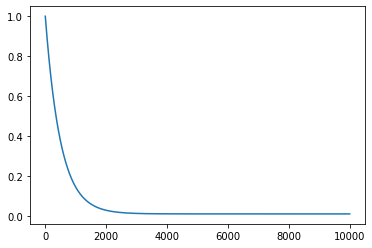

In [6]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

### Computing Temporal Difference Loss

In [7]:
def compute_td_loss(agent, batch_size, replay_buffer, optimizer, gamma):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    state = torch.tensor(np.float32(state)).type(dtype)
    next_state = torch.tensor(np.float32(next_state)).type(dtype)
    action = torch.tensor(action).type(dtypelong)
    reward = torch.tensor(reward).type(dtype)
    done = torch.tensor(done).type(dtype)

    # Normal DDQN update
    q_values = agent.q_network(state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # double q-learning
    online_next_q_values = agent.q_network(next_state)
    _, max_indicies = torch.max(online_next_q_values, dim=1)
    target_q_values = agent.target_q_network(next_state)
    next_q_value = torch.gather(target_q_values, 1, max_indicies.unsqueeze(1))

    expected_q_value = reward + gamma * next_q_value.squeeze() * (1 - done)
    loss = (q_value - expected_q_value.data.detach()).pow(2).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

### Update the target network

In [8]:
def soft_update(q_network, target_q_network, tau):
    for t_param, param in zip(target_q_network.parameters(), q_network.parameters()):
        if t_param is param:
            continue
        new_param = tau * param.data + (1.0 - tau) * t_param.data
        t_param.data.copy_(new_param)


def hard_update(q_network, target_q_network):
    for t_param, param in zip(target_q_network.parameters(), q_network.parameters()):
        if t_param is param:
            continue
        new_param = param.data
        t_param.data.copy_(new_param)
        
def update_target(q_network, target_q_network):
    target_q_network.load_state_dict(q_network.state_dict())

### Training

In [9]:
learning_rate = 0.001
target_update_rate = 0.1
gamma = 0.99
target_network_update_f = 100
num_timesteps = 10000
log_every = 200
batch_size = 32

def train(env):
    
    print(env.seq)
    
    # Q and target Q networks are global paraneters
    agent = Agent(env, q_network, target_q_network)
    optimizer = optim.Adam(q_network.parameters(), lr = learning_rate)
    
    losses, all_rewards = [], []
    episode_reward = 0
    state = env.reset()

    for ts in range(1, num_timesteps + 1):
        epsilon = epsilon_by_frame(ts)
        action = agent.act(state, epsilon)
        
        next_state, reward, done, _ = env.step(int(action.cpu()))
            
        replay_buffer.push(state, action, reward, next_state, done)

        state = next_state
        episode_reward += reward

        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        if len(replay_buffer) > batch_size:
            # Update the q-network & the target network
            loss = compute_td_loss(agent, batch_size, replay_buffer, optimizer, gamma)
            losses.append(loss.data)

            if ts % target_network_update_f == 0:
                # soft_update(agent.q_network, agent.target_q_network, target_update_rate)
                # hard_update(agent.q_network, agent.target_q_network)
                update_target(agent.q_network, agent.target_q_network)

        if ts % log_every == 0:
            out_str = "Timestep {}".format(ts)
            if len(all_rewards) > 0:
                out_str += ", Reward: {}".format(all_rewards[-1])
            if len(losses) > 0:
                out_str += ", TD Loss: {}".format(losses[-1])
            print(out_str)
        
    return losses, all_rewards, agent

### Plot Loss & Rewards

In [10]:
def plot(losses, rewards, save = False, net = "Linear"):
    plt.figure(figsize = (20,8))
    plt.subplot(121)
    plt.title("Rewards")
    plt.plot(rewards)
    plt.subplot(122)
    plt.title("Loss")
    plt.plot(losses)
    if save: plt.savefig('DQN({})RewardsLosses.pdf'.format(net))
    plt.show()

### Run trained agent on environment

In [11]:
def run_agent(env, agent):
    env = env
    agent = agent
    state = env.reset()
    cnt = 0
    while True:
        cnt += 1
        action = agent.act(state, 0)
        next_state, reward, done, info = env.step(int(action.cpu()))
        if cnt % 3 == 0:
            env.render()
        state=next_state
        if done:
            print("Reward: {} | Actions: {}".format(reward, info['actions']))
            env.render()
            break

### List of sequences

In [12]:
# seqs_list = open('seqs.txt', 'r')

## DQN with Linear Model

In [13]:
from lattice3d_linear_env import Lattice3DLinearEnv
from lattice2d_linear_env import Lattice2DLinearEnv

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.layers = nn.Sequential(
            nn.Linear(self.input_shape[0], 128), nn.ReLU(), nn.Linear(128, self.num_actions)
        )

    def forward(self, x):
        return self.layers(x)
    
linear_env = Lattice2DLinearEnv("HPHPPHHPHPPHPHH", grid_len = 31)
q_network = DQN(linear_env.observation_space.shape, linear_env.action_space.n)
target_q_network = DQN(linear_env.observation_space.shape, linear_env.action_space.n)

replay_size = 5000
replay_buffer = ReplayBuffer(replay_size)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

learning_rate = 0.001
target_update_rate = 0.1
gamma = 0.99
target_network_update_f = 200
num_timesteps = 20000
log_every = 1000
batch_size = 32

if USE_CUDA:
    q_network = q_network.cuda()
    target_q_network = target_q_network.cuda()

### Train on different sequences

In [14]:
# Env params
# collision_penalty = -2
# trap_penalty = 0.5

# max_seq_length = 5
# seq_dict = {}

# Train on all sequences with length <= max_seq_length
# for seq in seqs_list:
#     if len(seq) > max_seq_length:
#         break
#     else:
#         env = Lattice2DLinearEnv(seq, collision_penalty, trap_penalty)
#         if len(seq) <= 4:
#             reward, actions = env.all_combs()
#             seq_dict.update( {seq : reward})
#         else:
#             losses, rewards, agent = train(env)
#             seq_dict.update( {seq : rewards[-1]})

In [15]:
t0 = time.time()
linear_losses, linear_rewards, linear_agent = train(linear_env)
t1 = time.time()
print("Time taken: {}".format(t1 - t0))

HPHPPHHPHPPHPHH
Timestep 1000, Reward: 0, TD Loss: 0.046340182423591614
Timestep 2000, Reward: 1, TD Loss: 0.044192612171173096
Timestep 3000, Reward: 2, TD Loss: 0.007156199309974909
Timestep 4000, Reward: 1, TD Loss: 0.006794285494834185


C:\Users\binyu\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Your agent was trapped! Ending the episode.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Timestep 5000, Reward: 0, TD Loss: 0.02731599099934101
Timestep 6000, Reward: 1, TD Loss: 0.009324951097369194
Timestep 7000, Reward: 0, TD Loss: 0.012219391763210297
Timestep 8000, Reward: 0, TD Loss: 0.005624443758279085
Timestep 9000, Reward: 1, TD Loss: 0.007968351244926453
Timestep 10000, Reward: 1, TD Loss: 0.004088046960532665
Timestep 11000, Reward: 1, TD Loss: 0.009032226167619228
Timestep 12000, Reward: 1, TD Loss: 0.0006828870973549783
Timestep 13000, Reward: 2, TD Loss: 0.0015109124360606074
Timestep 14000, Reward: 2, TD Loss: 0.00037754044751636684
Timestep 15000, Reward: 1, TD Loss: 0.0002440245298203081
Timestep 16000, Reward: 1, TD Loss: 0.018321746960282326
Timestep 17000, Reward: 2, TD Loss: 0.000679799122735858
Timestep 18000, Reward: 3, TD Loss: 0.002731683198362589
Timestep 19000, Reward: 3, TD Loss: 0.00036145898047834635
Timestep 20000, Reward: 3, TD Loss: 2.4563298211432993e-05
131.95187544822693


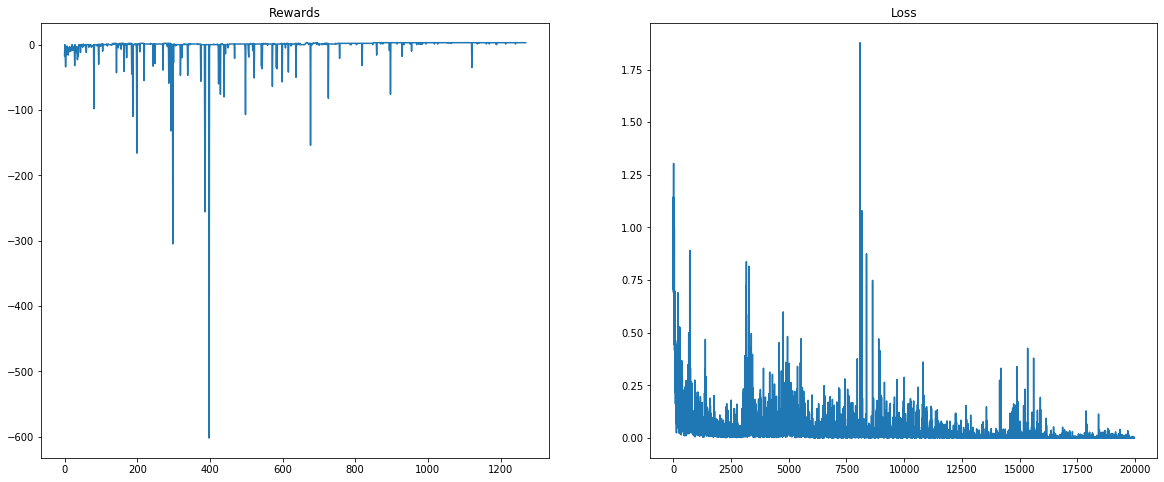

In [16]:
plot(linear_losses, linear_rewards)

Reward: 3 | Actions: ['D', 'L', 'D', 'R', 'R', 'D', 'R', 'U', 'U', 'R', 'D', 'R', 'D', 'L']


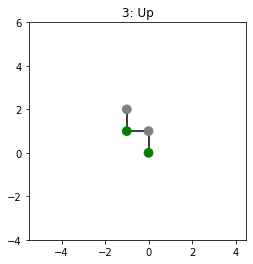

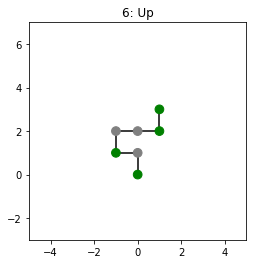

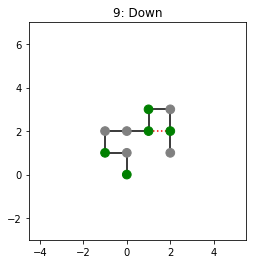

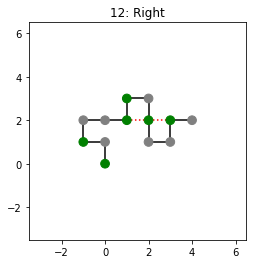

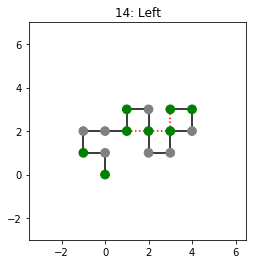

In [17]:
run_agent(linear_env, linear_agent)

## DQN with CNN Model

In [18]:
from lattice2d_cnn_env import Lattice2DCNNEnv

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.features = nn.Sequential(
            nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.zeros(1, *self.input_shape)).view(1, -1).size(1)

cnn_env = Lattice2DCNNEnv("HPHPPHHPHPPHPHH", grid_len = 41)
q_network = CnnDQN(cnn_env.observation_space.shape, cnn_env.action_space.n)
target_q_network = deepcopy(q_network)

replay_size = 10000
replay_buffer = ReplayBuffer(replay_size)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

learning_rate = 0.001
target_update_rate = 0.1
gamma = 0.99
target_network_update_f = 1000
num_timesteps = 100000
log_every = 5000
batch_size = 32

if USE_CUDA:
    q_network = q_network.cuda()
    target_q_network = target_q_network.cuda()

### Train on different sequences

In [19]:
# Env params
# collision_penalty = -2
# trap_penalty = 0.5
# 
# max_seq_length = 10
# seq_dict = {}
# 
# target_network_update_f = 1000
# num_timesteps = 1000000
# log_every = 10000

# Train on all sequences with length <= max_seq_length
# for seq in seqs_list:
#     if len(seq) > max_seq_length:
#         break
#     else:
#         env = Lattice2DLinearEnv(seq, collision_penalty, trap_penalty)
        # Brute force for sequences with length less than 4
#         if len(seq) <= 4:
#             reward, actions = env.all_combs()
#             seq_dict.update( {seq : reward})
#         else:
#             losses, rewards, agent = train(env)
#             seq_dict.update( {seq : rewards[-1]})

In [20]:
t0 = time.time()
cnn_losses, cnn_rewards, cnn_agent = train(cnn_env)
t1 = time.time()
print("Time taken: {}".format(t1 - t0))

HPHPPHHPHPPHPHH


C:\Users\binyu\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Your agent was trapped! Ending the episode.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Timestep 5000, Reward: 0, TD Loss: 0.02544994466006756
Timestep 10000, Reward: 0, TD Loss: 0.1130514070391655
Timestep 15000, Reward: 0, TD Loss: 0.008510705083608627
Timestep 20000, Reward: 2, TD Loss: 0.00553530128672719
Timestep 25000, Reward: 1, TD Loss: 0.02128368616104126
Timestep 30000, Reward: 3, TD Loss: 0.00016701468848623335
Timestep 35000, Reward: 4, TD Loss: 0.0005519762053154409
Timestep 40000, Reward: 4, TD Loss: 0.0005913466447964311
Timestep 45000, Reward: 2, TD Loss: 0.00037528807297348976
Timestep 50000, Reward: 4, TD Loss: 2.8789792850147933e-05
Timestep 55000, Reward: 4, TD Loss: 0.00010007144010160118
Timestep 60000, Reward: 4, TD Loss: 0.000774721207562834
Timestep 65000, Reward: 4, TD Loss: 2.502029929019045e-05
Timestep 70000, Reward: 4, TD Loss: 0.0001179829123429954
Timestep 75000, Reward: 4, TD Loss: 0.00017030417802743614
Timestep 80000, Reward: 4, TD Loss: 0.0007251063943840563
Timestep 85000, Reward: 4, TD Loss: 0.00015710407751612365
Timestep 90000, Rewa

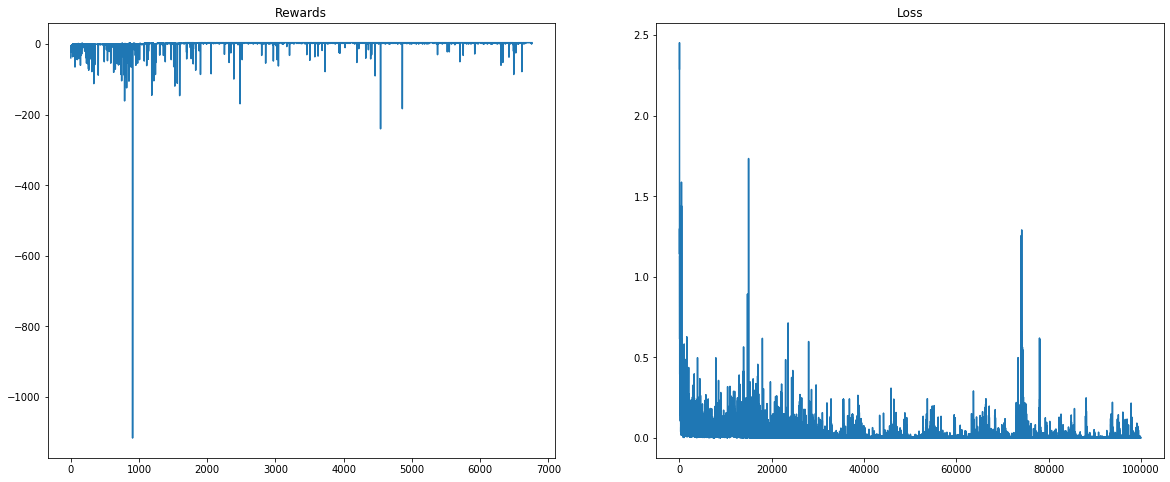

In [21]:
plot(cnn_losses, cnn_rewards)

Reward: 4 | Actions: ['U', 'L', 'L', 'D', 'R', 'D', 'R', 'R', 'D', 'L', 'L', 'L', 'U', 'L']


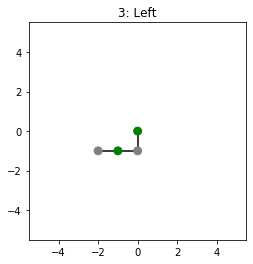

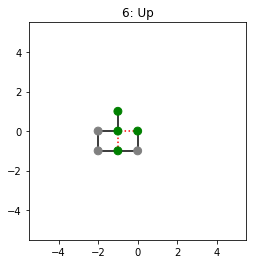

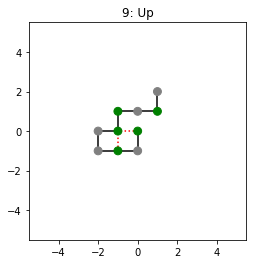

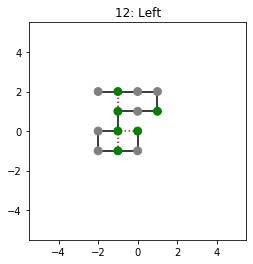

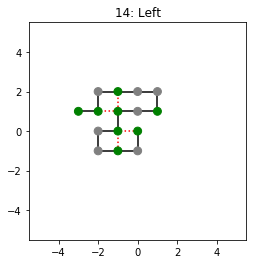

In [22]:
run_agent(cnn_env, cnn_agent)